<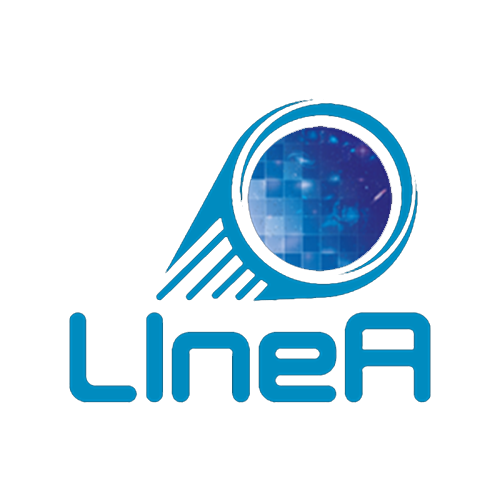

# DESI DR1 Spectroscopic Redshifts

Inspection of basic properties of the DESI DR1 catalog.

Contact: Luigi Silva ([luigi.silva@linea.org.br](mailto:luigi.silva@linea.org.br))

Last verified: Apr. 08, 2025

### Acknowledgments

*This notebook used computational resources from the Associação Laboratório Interinstitucional de e-Astronomia (LIneA) with financial support from the INCT of e-Universo (Process no. 465376/2014-2).*

*This notebook used data obtained with the Dark Energy Spectroscopic Instrument (DESI). DESI construction and operations is managed by the Lawrence Berkeley National Laboratory. This material is based upon work supported by the U.S. Department of Energy, Office of Science, Office of High-Energy Physics, under Contract No. DE–AC02–05CH11231, and by the National Energy Research Scientific Computing Center, a DOE Office of Science User Facility under the same contract. Additional support for DESI was provided by the U.S. National Science Foundation (NSF), Division of Astronomical Sciences under Contract No. AST-0950945 to the NSF’s National Optical-Infrared Astronomy Research Laboratory; the Science and Technology Facilities Council of the United Kingdom; the Gordon and Betty Moore Foundation; the Heising-Simons Foundation; the French Alternative Energies and Atomic Energy Commission (CEA); the National Council of Humanities, Science and Technology of Mexico (CONAHCYT); the Ministry of Science and Innovation of Spain (MICINN), and by the DESI Member Institutions: www.desi.lbl.gov/collaborating-institutions. The DESI collaboration is honored to be permitted to conduct scientific research on I’oligam Du’ag (Kitt Peak), a mountain with particular significance to the Tohono O’odham Nation. Any opinions, findings, and conclusions or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the U.S. National Science Foundation, the U.S. Department of Energy, or any of the listed funding agencies.*

See complete DESI Data License and Acknowledgements information [here](https://data.desi.lbl.gov/doc/acknowledgments/).

### Introduction

This notebook contains a brief characterization of the spectroscopic redshifts (spec-z) measurements in the DESI DR1 catalog, which has been publicly distributed and described in detail in scientific literature by DESI project.

The data presented here were obtained from the [DESI data release web page](https://data.desi.lbl.gov/doc/releases/dr1/).

The schema of the catalog can be found [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/v1/zpix-SURVEY-PROGRAM.html#hdu1). 

### Reference paper

[DESI Collaboration et al. (2025), Data Release 1 of the Dark Energy Spectroscopic Instrument](https://arxiv.org/pdf/2503.14745)

# Imports and configurations of libraries

## Importing the required libraries

Importing the libraries.

In [ ]:
### GENERAL
import os
import getpass
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from IPython.display import IFrame

### DASK
import dask.dataframe as dd
from dask.distributed import Client

### VISUALIZATION
# BOKEH
from bokeh.io import output_notebook

# GEOVIEWS
import geoviews as gv
import geoviews.feature as gf
from cartopy import crs

# HOLOVIEWS
import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import rasterize, dynspread

# DATASHADER
import datashader as ds

In [ ]:
hv.extension('bokeh')
gv.extension('bokeh')
output_notebook()

In [ ]:
pd.set_option("display.float_format", lambda x: f"{x:.6f}" if 1e-7 <= abs(x) <= 1e8 else f"{x:.3e}")

## Setting up a local cluster with dask

Defining a local Dask Client.

In [ ]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit="7GB")

Printing info about the Client.

In [ ]:
client

Printing info about the Dask Dashboard.

In [ ]:
user = getpass.getuser()
dashboard_url = f"https://jupyter.linea.org.br/user/{user}/proxy/8787/status"

#display(Markdown(f"You can see the dashboard at: [{dashboard_url}]({dashboard_url})"))

# Reading the entire catalog with Dask

## Defining the path to the input files

Defining the path to the input files.

In [ ]:
input_dir = "/home/luigi.silva/DESI/DR1/DATA/PARQUET"
input_pattern = "*.parquet"

input_files = os.path.join(input_dir, input_pattern)

## Reading the catalog

Reading the catalog with Dask.

In [ ]:
ddf_input = dd.read_parquet(input_files)

# Data characterization

## Full catalog

In [ ]:
input_nrows = ddf_input.shape[0].compute()

print(f"Total number of lines (full catalog): {input_nrows}")

In [ ]:
input_cols = ddf_input.columns
input_ncols = len(input_cols)

print(f"Total number of columns (full catalog): {input_ncols}")

In [ ]:
print("Columns names (full catalog): \n")
print(input_cols.to_list())

## Filtered catalog

### Applying the ```SPECTYPE==GALAXY``` and ```ZCAT_PRIMARY==True``` filters

Applying the ```SPECTYPE==GALAXY``` and ```ZCAT_PRIMARY==True``` filters in the catalog.

In [ ]:
ddf_filtered = ddf_input[ddf_input["SPECTYPE"]=="GALAXY"]

In [ ]:
ddf_filtered = ddf_filtered[ddf_filtered["ZCAT_PRIMARY"]==True]

### Selecting the columns of interest

Selecting the columns of interest in the catalog.

In [ ]:
selected_cols = [
    'TARGETID', 'HEALPIX', 'Z', 'ZERR', 'ZWARN',
    'TARGET_RA', 'TARGET_DEC', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1',
    'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1',
    'FLUX_IVAR_W2'
]

print(selected_cols)

In [ ]:
ddf_filtered = ddf_filtered[selected_cols]

ddf_filtered = ddf_filtered.persist()

### Number of lines and columns

In [ ]:
filtered_nrows = ddf_filtered.shape[0].compute()

print(f"Total number of lines (filtered catalog): {filtered_nrows}")

In [ ]:
filtered_cols = ddf_filtered.columns
filtered_ncols = len(filtered_cols)

print(f"Total number of columns (filtered catalog): {filtered_ncols}")

In [ ]:
print("Columns names (filtered catalog): \n")
print(filtered_cols.to_list())

### First lines of the catalog

In [ ]:
ddf_filtered.head()

### Basic statistics

In [ ]:
ddf_filtered.describe().compute()

### Spatial distribution plot

Getting RA and DEC columns in the Dask Dataframe.

In [ ]:
ddf_ra_dec = ddf_filtered[['TARGET_RA', 'TARGET_DEC']]

Changing RA to the $[-180^{\circ}, 180^{\circ})$ interval.

In [ ]:
ddf_ra_dec['RA_SHIFTED'] = ((ddf_ra_dec['TARGET_RA'] + 180) % 360) - 180

#### Plot using the Plate Carrée projection

Defining the points element.

In [ ]:
hv_points = hv.Points(ddf_ra_dec[['RA_SHIFTED', 'TARGET_DEC']], kdims=['RA_SHIFTED', 'TARGET_DEC'])

Defining the title, the axis labels and the plot sizes.

In [ ]:
title = 'Spatial Distribution - SPECTYPE==GALAXY and ZCAT_PRIMARY==True - Plate Carrée Projection'
height = 500
width = 1000
padding = 0.05

Making the plot with geoviews and datashader.

In [ ]:
Plate_Carree_rasterized_points = rasterize(hv_points, aggregator=ds.count()).opts(cmap="Viridis", cnorm='log')

Plate_Carree_spread_points = dynspread(Plate_Carree_rasterized_points).opts(
    width=width, height=height, padding=padding, title=title, toolbar='above', colorbar=True,
    tools=['box_select'], show_grid=True, 
    invert_xaxis=True  
)

# For a dynamic plot, uncoment the line below.
Plate_Carree_spread_points

In [ ]:
#hv.save(Plate_Carree_spread_points, 'plate_carree_spatial_distribution.html', backend='bokeh')

In [ ]:
#IFrame('plate_carree_spatial_distribution.html', width=1200, height=600)

#### Plot using the Mollweide projection

Defining the points element.

In [ ]:
gv_points = gv.Points(ddf_ra_dec[['RA_SHIFTED', 'TARGET_DEC']], kdims=['RA_SHIFTED', 'TARGET_DEC']).opts(
    projection=crs.PlateCarree()
)

Defining the title, the axis labels and the plot sizes.

In [ ]:
title = 'Spatial Distribution - SPECTYPE==GALAXY and ZCAT_PRIMARY==True - Mollweide Projection'
height = 500
width = 1000
padding = 0.05

Defining the RA and DEC ticks for the Mollweide projection.

In [ ]:
longitudes = np.arange(30, 360, 30)
latitudes = np.arange(-75, 76, 15)

lon_labels = [f"{lon}°" for lon in longitudes]
lon_labels.reverse()
lat_labels = [f"{lat}°" for lat in latitudes]

labels_data = {
    "lon": list(np.flip(longitudes)) + [180] * len(latitudes),
    "lat": [0] * len(longitudes) + list(latitudes),
    "label": lon_labels + lat_labels,
}

df_labels = pd.DataFrame(labels_data)

labels_plot = gv.Labels(df_labels, kdims=["lon", "lat"], vdims=["label"]).opts(
    text_font_size="12pt",
    text_color="black",
    text_align='right',
    text_baseline='bottom',
    projection=crs.Mollweide()
)

Making the plot with datashader.

In [ ]:
Mollweide_rasterized_points = rasterize(gv_points, aggregator=ds.count()).opts(cmap="Viridis", cnorm='log')

Mollweide_spread_points = dynspread(Mollweide_rasterized_points).opts(
    width=width, height=height, padding=padding, title=title, toolbar='above', colorbar=True,
    invert_xaxis=True
)

grid = gf.grid()

final_mollweide_plot = (Mollweide_spread_points).opts(
    opts.RGB(projection=crs.Mollweide())
) * grid * labels_plot

# For a dynamic plot, uncoment the line below.
final_mollweide_plot

In [ ]:
#hv.save(final_mollweide_plot, 'mollweide_spatial_distribution.html', backend='bokeh')

In [ ]:
#IFrame('mollweide_spatial_distribution.html', width=1200, height=600)

### Redshift plot

In [ ]:
z_values = ddf_filtered['Z'].compute()

In [ ]:
redshift = hv.Dimension('z', label='spec-z')
(count, z_bin) = np.histogram(z_values, bins=np.arange(0,2,0.01))

In [ ]:
z_distribution = hv.Histogram((count, z_bin), kdims=redshift).opts(
    title='Redshift Distribution', xlabel='spec-z', height=400, width=800,  xlim=(0.,2.))   
z_distribution